# Reproducing script for: Re-examining thresholds of continuous democracy measures (Kasuya & Mori, Contemporary Politics 2021)

Paper Link: https://www.tandfonline.com/doi/full/10.1080/13569775.2021.1993564

## Data Sources

- V-Dem v10: https://www.v-dem.net/en/data/archive/previous-data/v-dem-dataset/
- CGV v3.2: http://www.christianbjoernskov.com/wp-content/uploads/2020/09/Bj%C3%B8rnskov-Rode-integrated-dataset-v3.2.xlsx
- GWF: http://sites.psu.edu/dictators/wp-content/uploads/sites/12570/2016/05/GWF-Autocratic-Regimes-1.2.zip
- BMR v3: https://sites.google.com/site/mkmtwo/democracy-v3.0.csv
- LIED v6: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WPKNIT
- Mainwaring et al. (2001): https://link.springer.com/article/10.1007/BF02687584
- Country code: https://github.com/vincentarelbundock/countrycode

In [1]:
# Dependency management
libraries <- c("readr", "dplyr", "tidyr", "ggplot2", "cowplot", "stringr", "sqldf")
for (l in libraries) {
  if (!require(l, character.only=TRUE)) {
    install.packages(l)
    require(l, character.only=TRUE)
  }
}

Loading required package: readr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: ggplot2

Loading required package: cowplot

Loading required package: stringr

Loading required package: sqldf

Loading required package: gsubfn

Loading required package: proto

Loading required package: RSQLite



In [2]:
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(sqldf)

OUTDIR <- "outputs"
if (!dir.exists(OUTDIR)) dir.create(OUTDIR, recursive=TRUE)

figsize <- function(width, height) {
  options(repr.plot.width=width, repr.plot.height=height)
}

savefigs <- function(prefix, ..., dpi=600) {
  for (ext in c("jpeg", "tiff")) {
    filename <- file.path(OUTDIR, paste0(prefix, ".", ext))
    ggsave(filename, ..., dpi=dpi)
  }
}

theme_default <- theme_bw() + 
  theme(
     strip.background=element_blank()
    ,strip.text=element_text(face="bold")
    #,panel.grid.major=element_blank()
    ,panel.grid.minor=element_blank()  
  )

theme_set(theme_default)

In [3]:
## Get master data

x <- read_csv("threshold-main.csv.gz")
cat("Data shape:", dim(x))
head(x)

Rows: 18787 Columns: 24

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): countryName, region, countryNameBMR, countryNameCGV, countryNameGW...
dbl (17): countryId, year, Polyarchy, Polity, FH, BMR, BMR_female, CGV, GWF,...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Data shape: 18787 24

countryId,year,countryName,region,Polyarchy,Polity,FH,BMR,BMR_female,CGV,⋯,countryNameGWF,countryNameCGV3,countryNameLIED6,lied6_1,lied6_2,lied6_3,lied6_4,lied6_5,lied6_6,lied6_7
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36,1900,Afghanistan,Asia and Pacific,0.023,-6,NA,0,0,NA,⋯,NA,NA,Afghanistan,0,0,0,0,0,0,0
36,1901,Afghanistan,Asia and Pacific,0.023,-6,NA,0,0,NA,⋯,NA,NA,Afghanistan,0,0,0,0,0,0,0
36,1902,Afghanistan,Asia and Pacific,0.033,-6,NA,0,0,NA,⋯,NA,NA,Afghanistan,0,0,0,0,0,0,0
36,1903,Afghanistan,Asia and Pacific,0.033,-6,NA,0,0,NA,⋯,NA,NA,Afghanistan,0,0,0,0,0,0,0
36,1904,Afghanistan,Asia and Pacific,0.033,-6,NA,0,0,NA,⋯,NA,NA,Afghanistan,0,0,0,0,0,0,0
36,1905,Afghanistan,Asia and Pacific,0.033,-6,NA,0,0,NA,⋯,NA,NA,Afghanistan,0,0,0,0,0,0,0


In [4]:
## Table 2. Fraction of country-year pairs in aggreement

cols <- c("BMR", "CGV", "GWF")

cat("Pearson correlation")
cor(x[cols], use="pairwise.complete.obs")

agreements <- matrix(NA, nrow=length(cols), ncol=length(cols))
colnames(agreements) <- cols
rownames(agreements) <- cols
for (c1 in cols) {
  for (c2 in cols) {
    if (c1 < c2) next
    
    agree <- mean(x[c1] == x[c2], na.rm=TRUE)
    agreements[c1, c2] <- agree
  }
}

cat("Pairwise agreements ratio")
agreements

Pearson correlation

,BMR,CGV,GWF
BMR,1.0000000,0.9008907,0.8898003
CGV,0.9008907,1.0000000,0.9013727
GWF,0.8898003,0.9013727,1.0000000


Pairwise agreements ratio

,BMR,CGV,GWF
BMR,1.0000000,NA,NA
CGV,0.9511760,1.0000000,NA
GWF,0.9466032,0.9518581,1


Joining, by = c("countryName", "year")



[1] 78828     6

countryName,year,contVar,contVal,binVar,binVal
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
Afghanistan,1900,EDI/RoW,0.023,BMR,0
Afghanistan,1900,Polity,-6.000,BMR,0
Afghanistan,1901,EDI/RoW,0.023,BMR,0
Afghanistan,1901,Polity,-6.000,BMR,0
Afghanistan,1902,EDI/RoW,0.033,BMR,0
Afghanistan,1902,Polity,-6.000,BMR,0


`summarise()` has grouped output by 'contVar'. You can override using the `.groups` argument.



contVar,binVar,nobs,ncountry,minYear,maxYear
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
EDI/RoW,BMR,12433,177,1900,2015
EDI/RoW,CGV,10879,169,1950,2019
EDI/RoW,GWF,7703,152,1945,2009
FH,BMR,6839,177,1972,2015
FH,CGV,7248,169,1972,2018
FH,GWF,4991,152,1972,2009
Polity,BMR,11931,169,1900,2015
Polity,CGV,9205,162,1950,2018
Polity,GWF,7599,151,1945,2009


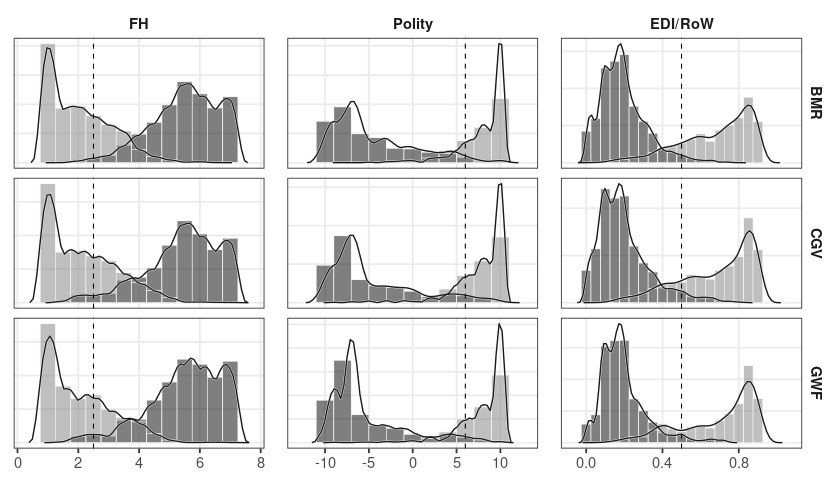

In [5]:
## Figure 1. Distribution of continuous measures by binary classification

makeHistData <- function(x, 
                         contvars=c("Polyarchy", "Polity", "FH"), 
                         binvars=c("BMR", "CGV", "GWF")) {
  tmp1 <- x[c("countryName", "year", contvars)] %>%
    pivot_longer(cols=-c(countryName, year), names_to="contVar", values_to="contVal")
  tmp2 <- x[c("countryName", "year", binvars)] %>%
    pivot_longer(cols=-c(countryName, year), names_to="binVar", values_to="binVal")
  out <- inner_join(tmp1, tmp2)
  out <- drop_na(out)
    
  out$contVar[out$contVar=="Polyarchy"] <- "EDI/RoW"
  out$binVar[out$binVar=="BMR_female"] <- "BMR(female)"
  out
}

makeHist <- function(data, contvar, binwidth=1, xintercept=NULL, nostrip=TRUE) {
  tmp <- filter(data, contVar==contvar) 
  # density estimate by binVar
  tmp2 <- NULL
  for (b in unique(tmp$binVar)) {
    for (v in unique(tmp$binVal)) {
      flg <- (tmp$binVar==b) & (tmp$binVal==v)
      k <- density(tmp$contVal[flg], n=64, kernel="cosine")
      wid <- (max(k$x)-min(k$x)) / (length(k$x)-1)
      tmp2 <- rbind(tmp2,
                    data.frame(binVar=b, binVal=v, contVal=k$x, dens=k$y,
                               dens_scaled=k$y*sum(flg)/sum(k$y)/(wid/binwidth), 
                               stringsAsFactors=FALSE))
    }
  }
  g <- ggplot(tmp, aes(contVal, fill=factor(binVal))) +
    geom_histogram(position="identity", binwidth=binwidth, alpha=0.5, color="grey95", size=0.2) +
    facet_grid(vars(binVar), vars(contVar), scales="free") +
    scale_fill_grey(start=0.0, end=0.5) +
    geom_path(aes(x=contVal, y=dens_scaled, group=binVal), data=tmp2, color="white", size=0.6) +
    geom_path(aes(x=contVal, y=dens_scaled, group=binVal), data=tmp2, color="gray10", size=0.4) +
    #geom_density(aes(y=..count..), alpha=0, color="white", n=128, kernel="cosine", size=0.6) +
    #geom_density(aes(y=..count..), alpha=0, color="gray10", n=128, kernel="cosine", size=0.4) +
    #geom_freqpoly(alpha=1, color="white", binwidth=binwidth, size=0.6) +
    #geom_freqpoly(alpha=1, color="gray10", binwidth=binwidth, size=0.4) +
    theme_default +
    theme(
       legend.position="none"
      ,axis.title.x=element_blank()
      ,axis.title.y=element_blank()
      ,axis.text.y=element_blank()
      ,axis.ticks.y=element_blank()
    )
  if (nostrip) g <- g + theme(strip.background.y=element_blank(), strip.text.y=element_blank())
  if (!is.null(xintercept)) g <- g + geom_vline(xintercept=xintercept, linetype="dashed", size=0.3)
  g  
}


y <- makeHistData(x)
# remane polyarchy -> V-Dem
#y$contVar[y$contVar=="Polyarchy"] <- "V-Dem"
dim(y)
head(y)
group_by(y, contVar, binVar) %>%
  summarize(nobs=n(), ncountry=length(unique(countryName)),
            minYear=min(year), maxYear=max(year))


g1 <- makeHist(y, "FH", binwidth=0.5, xintercept=2.5)
g2 <- makeHist(y, "Polity", binwidth=2, xintercept=6)
g3 <- makeHist(y, "EDI/RoW", binwidth=0.05, xintercept=0.5, nostrip=FALSE)

figsize(7, 4)
g <- plot_grid(g1, g2, g3, ncol=3, rel_widths=c(1, 1, 1.07))
g
savefigs("figure1_histograms", g, width=7, height=4)

`summarise()` has grouped output by 'contVar'. You can override using the `.groups` argument.



,contVar,binVar,threshold,nobs,TP,TN,matched,consistency
,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,EDI/RoW,BMR,0.00,12433,5053,0,5053,0.4064184
2,EDI/RoW,BMR,0.01,12433,5053,51,5104,0.4105204
3,EDI/RoW,BMR,0.02,12433,5053,286,5339,0.4294217
4,EDI/RoW,BMR,0.03,12433,5053,512,5565,0.4475991
5,EDI/RoW,BMR,0.04,12433,5053,614,5667,0.4558031
6,EDI/RoW,BMR,0.05,12433,5052,637,5689,0.4575726


`summarise()` has grouped output by 'contVar'. You can override using the `.groups` argument.

Joining, by = c("contVar", "binVar", "consistency")

`summarise()` has grouped output by 'contVar', 'binVar'. You can override using the `.groups` argument.

Joining, by = c("contVar", "threshold")



contVar,binVar,consistency,thresholds,threshold
<chr>,<chr>,<dbl>,<chr>,<dbl>
EDI/RoW,Average,0.9154962,0.39,0.39
EDI/RoW,BMR,0.9247969,0.39,0.39
EDI/RoW,BMR-female,0.9176518,0.48,0.48
EDI/RoW,CGV,0.9041272,0.39,0.39
EDI/RoW,GWF,0.9175646,0.39,0.39
FH,Average,0.9104665,3.5,3.50
FH,BMR,0.9315689,3.5,3.50
FH,BMR-female,0.9315689,3.5,3.50
FH,CGV,0.8927980,3.5,3.50


contVar,binVar,consistency,threshold
<chr>,<chr>,<dbl>,<dbl>
EDI/RoW,BMR,0.9085498,0.5
EDI/RoW,BMR-female,0.9161238,0.5
EDI/RoW,CGV,0.8892361,0.5
EDI/RoW,GWF,0.8954953,0.5
EDI/RoW,Average,0.8977604,0.5
Polity,BMR,0.9264102,6.0
Polity,BMR-female,0.9130981,6.0
Polity,CGV,0.9020098,6.0
Polity,GWF,0.9269641,6.0


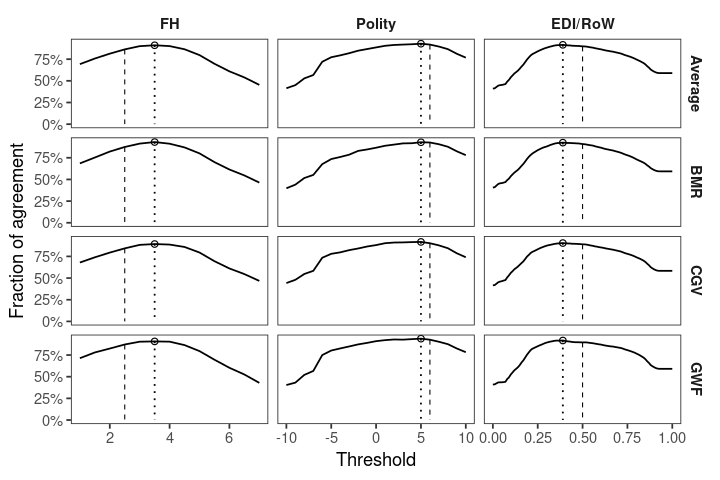

In [6]:
# Figure 2. Fraction of agreement by threshold

getConsitency <- function(data, contVar, binVar, threshold, ineq=`>=`) {
  tmp <- data[c(contVar, binVar)] %>% drop_na()
  cont <- tmp[[contVar]]
  bin  <- tmp[[binVar]]
  derived <- as.integer(ineq(cont, threshold))
  
  out <- data.frame(
     contVar=contVar, binVar=binVar, threshold=threshold
    ,nobs=nrow(tmp)
    ,TP=sum(derived==bin & bin==1)
    ,TN=sum(derived==bin & bin==0)
    ,matched=sum(derived==bin)
    ,consistency=mean(derived==bin)
    ,stringsAsFactors=FALSE
  )
  out
}

getConsistencyAll <- function(data, contVar, binVar, thresholds, ineq=`>=`) {
  out <- NULL
  for (th in thresholds) {
    out <- rbind(out, getConsitency(data, contVar, binVar, th, ineq))
  }  
  out
}

makeConsitencyData <- function(data) {
  z <- NULL
  for (contVar in c("Polyarchy", "Polity", "FH")) {
    thresholds <- if (contVar=="Polyarchy") seq(0, 1, 0.01) else
                  if (contVar=="Polity")    seq(-10, 10, 1) else
                  if (contVar=="FH")        seq(1, 7, 0.5) else
                  stop()
    ineq <- if (contVar=="FH") `<=` else `>=`
    for (binVar in c("BMR", "BMR_female", "CGV", "GWF")) {
      tmp <- getConsistencyAll(data, contVar, binVar, thresholds, ineq) 
      z <- rbind(z, tmp)                  
    }
  }

  # add average of (BMR, CGV, GWF)
  tmp <- filter(z, binVar %in% c("BMR", "CGV", "GWF")) %>%
    group_by(contVar, threshold) %>%
    summarize(binVar="Average",
              nobs=sum(nobs),              
              TP=sum(TP),
              TN=sum(TN),
              matched=sum(matched),
              consistency=mean(consistency)) %>%
    ungroup()
  z <- rbind(z, tmp)
}

z <- makeConsitencyData(x)
z$contVar[z$contVar=="Polyarchy"] <- "EDI/RoW"
z$binVar[z$binVar=="BMR_female"] <- "BMR-female"
head(z)

# find the best cut point and merge the default cut point
w1 <- group_by(z, contVar, binVar) %>%
  summarize(consistency=max(consistency)) %>%
  ungroup() %>%
  inner_join(select(z, contVar, binVar, consistency, threshold)) %>%
  group_by(contVar, binVar, consistency) %>%
  summarize(
    thresholds=paste(threshold, collapse=", "),  # keep all best threholds
    threshold=median(threshold)
  )
w2 <- data.frame(contVar=c("EDI/RoW", "Polity", "FH"),
                 threshold=c(0.5, 6, 2.5),
                 stringsAsFactors=FALSE) %>%
  inner_join(z) %>%
  select(contVar, binVar, consistency, threshold)
w1
w2


z$contVar <- factor(z$contVar, levels=c("FH", "Polity", "EDI/RoW"))
w1$contVar <- factor(w1$contVar, levels=c("FH", "Polity", "EDI/RoW"))
w2$contVar <- factor(w2$contVar, levels=c("FH", "Polity", "EDI/RoW"))

g <- filter(z, binVar %in% c("Average", "BMR", "CGV", "GWF")) %>%
  ggplot(aes(threshold, consistency)) +
  geom_line() +
  xlab("Threshold") + ylab("Fraction of agreement") +
  facet_grid(vars(binVar), vars(contVar), scales="free_x") +
  scale_y_continuous(labels=scales::percent_format(accuracy=1)) +
  theme_default +
  theme(panel.grid.major=element_blank())
tmp1 <- filter(w1, binVar %in% c("Average", "BMR", "CGV", "GWF"))
tmp2 <- filter(w2, binVar %in% c("Average", "BMR", "CGV", "GWF"))
g <- g +
  geom_segment(aes(xend=threshold, yend=0), data=tmp1, linetype="dotted", size=0.5) +
  geom_segment(aes(xend=threshold, yend=0), data=tmp2, linetype="dashed", size=0.3) +
  geom_point(aes(threshold, consistency), data=tmp1, shape=1, size=1.5)
figsize(6, 4)
g
savefigs("figure2_fractions-of-agreement", g, width=6, height=4)

In [7]:
## Table 3. Cut-off point estimates

u1 <- w1 %>% 
  rename(optimal_agreement=consistency, optimal_threshold=threshold, optimal_thresholds=thresholds) 
u2 <- inner_join(w2, z) %>% 
  rename(conventional_agreement=consistency, conventional_threshold=threshold) %>%
  select(-c(TP, TN, matched))
u <- inner_join(u1, u2) %>%
  select(contVar, binVar,
         conventional_threshold, conventional_agreement, 
         optimal_threshold, optimal_agreement, optimal_thresholds, 
         nobs)
u %>% filter(binVar=="Average") %>% arrange(contVar)

Joining, by = c("contVar", "binVar", "consistency", "threshold")

Joining, by = c("contVar", "binVar")



contVar,binVar,conventional_threshold,conventional_agreement,optimal_threshold,optimal_agreement,optimal_thresholds,nobs
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
FH,Average,2.5,0.8630858,3.50,0.9104665,3.5,19078
Polity,Average,6.0,0.9184613,5.00,0.9284847,5,28735
EDI/RoW,Average,0.5,0.8977604,0.39,0.9154962,0.39,31015


In [8]:
## Table A2. Cut-off point estimates by benchmarks separately
u %>% filter(binVar %in% c("BMR", "CGV", "GWF")) %>% arrange(contVar)

contVar,binVar,conventional_threshold,conventional_agreement,optimal_threshold,optimal_agreement,optimal_thresholds,nobs
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
FH,BMR,2.5,0.8748355,3.50,0.9315689,3.5,6839
FH,CGV,2.5,0.8428532,3.50,0.8927980,3.5,7248
FH,GWF,2.5,0.8715688,3.50,0.9070327,3.5,4991
Polity,BMR,6.0,0.9264102,5.00,0.9294275,5,11931
Polity,CGV,6.0,0.9020098,5.00,0.9172189,5,9205
Polity,GWF,6.0,0.9269641,5.00,0.9388077,5,7599
EDI/RoW,BMR,0.5,0.9085498,0.39,0.9247969,0.39,12433
EDI/RoW,CGV,0.5,0.8892361,0.39,0.9041272,0.39,10879
EDI/RoW,GWF,0.5,0.8954953,0.39,0.9175646,0.39,7703


Joining, by = "contVar"

`summarise()` has grouped output by 'contVar', 'binVar'. You can override using the `.groups` argument.



contVar,binVar,threshold,nobs,Pos,Neg,TP,TN,matched,TPR,TNR,Consistency
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
EDI/RoW,BMR,best,12433,5053,7380,4610,6888,11498,0.9123293,0.9333333,0.9247969
EDI/RoW,BMR,suggested,12433,5053,7380,4104,7192,11296,0.8121908,0.9745257,0.9085498
EDI/RoW,CGV,best,10879,4531,6348,4075,5761,9836,0.8993600,0.9075299,0.9041272
EDI/RoW,CGV,suggested,10879,4531,6348,3610,6064,9674,0.7967336,0.9552615,0.8892361
EDI/RoW,GWF,best,7703,3152,4551,2827,4241,7068,0.8968909,0.9318831,0.9175646
EDI/RoW,GWF,suggested,7703,3152,4551,2499,4399,6898,0.7928299,0.9666007,0.8954953


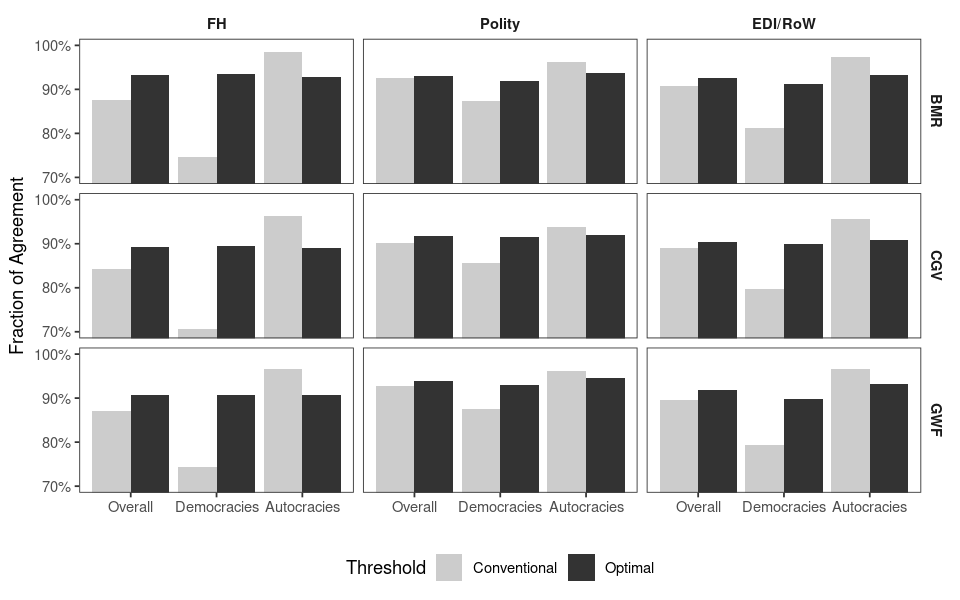

In [9]:
## Figure A1. Comparision of agreement

thres <- ungroup(u) %>% 
  filter(binVar=="Average") %>% 
  select(contVar, optimal_threshold, conventional_threshold)

makeConfData <- function(y, thres) {
  thres$contVar <- as.character(thres$contVar)  
  out <- inner_join(y, thres)

  out <- out %>%
    mutate(
       democracySuggested=ifelse(contVar=="FH", 
                                 contVal <= conventional_threshold,
                                 contVal >= conventional_threshold)
      ,democracyBest=ifelse(contVar=="FH", 
                            contVal <= optimal_threshold,
                            contVal >= optimal_threshold)
    ) %>%
    mutate(regime_suggested=ifelse(democracySuggested, "Democracy", "Autocracy"),
           regime_best=ifelse(democracyBest, "Democracy", "Autocracy")) %>%
    mutate(regime_binary=ifelse(binVal==1, "Democracy", "Autocracy"))

  out <- select(out, contVar, binVar, regime_binary, regime_suggested, regime_best) %>%
    pivot_longer(cols=-c(contVar, binVar, regime_binary),
                 names_to="threshold", names_prefix="regime_", values_to="regime_derived")
    
  out <- group_by(out, contVar, binVar, threshold) %>%
    summarize(
       nobs=n()
      ,Pos=sum(regime_binary=="Democracy")
      ,Neg=sum(regime_binary=="Autocracy")
      ,TP=sum(regime_binary==regime_derived & regime_binary=="Democracy")
      ,TN=sum(regime_binary==regime_derived & regime_binary=="Autocracy")
      ,matched=sum(regime_binary==regime_derived)  
    ) %>%
    mutate(TPR=TP/Pos, TNR=TN/Neg, Consistency=matched/nobs) 
  out
}

p <- makeConfData(y, thres)
head(p)

tmp <- select(p, contVar, binVar, threshold, TPR, TNR, Consistency) %>%
  pivot_longer(cols=-c(contVar, binVar, threshold)) %>%
  rename(Threshold=threshold)
tmp$name[tmp$name=="Consistency"] <- "Overall"
tmp$name[tmp$name=="TPR"] <- "Democracies"
tmp$name[tmp$name=="TNR"] <- "Autocracies"
tmp$name <- factor(tmp$name, levels=c("Overall", "Democracies", "Autocracies"))
tmp$Threshold[tmp$Threshold=="best"] <- "Optimal"
tmp$Threshold[tmp$Threshold=="suggested"] <- "Conventional"
tmp$contVar[tmp$contVar=="EDI"] <- "EDI/RoW"
tmp$contVar <- factor(tmp$contVar, levels=c("FH", "Polity", "EDI/RoW"))

tmp$Threshold <- factor(tmp$Threshold, levels=c("Conventional", "Optimal"))
g <- ggplot(tmp, aes(name, weight=value, fill=Threshold)) +
  geom_bar(position="dodge") +
  facet_grid(vars(binVar), vars(contVar)) +
  scale_fill_grey(start=0.8, end=0.2) +
  theme_default +
  coord_cartesian(ylim=c(0.7, 1)) +
  scale_y_continuous(labels=scales::percent_format(accuracy=1)) +
  xlab(element_blank()) + ylab("Fraction of Agreement") +
  theme(legend.position="bottom",
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank())

figsize(8, 5)
g
savefigs("figureA1_agreement-comparison", g, width=8, height=5)

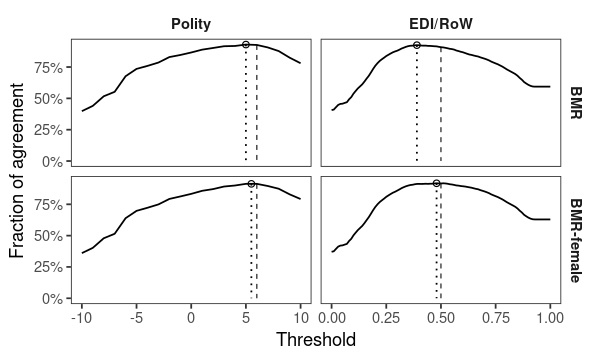

In [10]:
## Figure 3. BMR vs BMR with female suffrage

g <- filter(z, binVar %in% c("BMR", "BMR-female"), contVar != "FH") %>%
  ggplot(aes(threshold, consistency)) +
  geom_line() +
  xlab("Threshold") + ylab("Fraction of agreement") +
  facet_grid(vars(binVar), vars(contVar), scales="free_x") +
  scale_y_continuous(labels=scales::percent_format(accuracy=1)) +
  theme_default +
  theme(panel.grid.major=element_blank())
tmp1 <- filter(w1, binVar %in% c("BMR", "BMR-female"), contVar != "FH")
tmp2 <- filter(w2, binVar %in% c("BMR", "BMR-female"), contVar != "FH")
g <- g +
  geom_segment(aes(xend=threshold, yend=0), data=tmp1, linetype="dotted", size=0.5) +
  geom_segment(aes(xend=threshold, yend=0), data=tmp2, linetype="dashed", size=0.3) +
  geom_point(aes(threshold, consistency), data=tmp1, shape=1, size=1.5)
figsize(5, 3)
g
savefigs("figure3_fractions-of-agreement-bmr-female", g, width=5, height=3)

In [11]:
## Table 4. Optimal threshold for LIED classes

makeLIEDConsitencyData <- function(data) {
  z <- NULL
  for (contVar in c("Polyarchy", "Polity", "FH")) {
    thresholds <- if (contVar=="Polyarchy") seq(0, 1, 0.01) else
                  if (contVar=="Polity")    seq(-10, 10, 1) else
                  if (contVar=="FH")        seq(1, 7, 0.5) else
                  stop()
    ineq <- if (contVar=="FH") `<=` else `>=`
      
    for (binVar in paste0("lied6_", 1:7)) {
      tmp <- getConsistencyAll(data, contVar, binVar, thresholds, ineq) 
      z <- rbind(z, tmp)                  
    }
  }
  z
}

for (l in 1:7) {
  x[[paste0("lied6_", l)]] <- as.integer(x$LIED6 >= l)
}

z <- makeLIEDConsitencyData(x) %>% rename(agreement=consistency)
z$lied6_class <- gsub("lied6_", "LIED6>=", z$binVar)
z$contVar[z$contVar=="Polyarchy"] <- "EDI/RoW"
z$contVar <- factor(z$contVar, levels=c("FH", "Polity", "EDI/RoW"))
head(z)
  
thres_lied6 <- group_by(z, contVar, lied6_class) %>%
  summarize(agreement=max(agreement)) %>%
  ungroup() %>%
  inner_join(select(z, contVar, lied6_class, threshold, agreement))

thres_lied6 %>%
  pivot_wider(id_cols=lied6_class, names_from=contVar, values_from=c(threshold, agreement))

,contVar,binVar,threshold,nobs,TP,TN,matched,agreement,lied6_class
,<fct>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<chr>
1,EDI/RoW,lied6_1,0.00,18455,12778,0,12778,0.6923869,LIED6>=1
2,EDI/RoW,lied6_1,0.01,18455,12778,167,12945,0.7014359,LIED6>=1
3,EDI/RoW,lied6_1,0.02,18455,12775,915,13690,0.7418044,LIED6>=1
4,EDI/RoW,lied6_1,0.03,18455,12751,1705,14456,0.7833108,LIED6>=1
5,EDI/RoW,lied6_1,0.04,18455,12712,2308,15020,0.8138716,LIED6>=1
6,EDI/RoW,lied6_1,0.05,18455,12623,2736,15359,0.8322406,LIED6>=1


`summarise()` has grouped output by 'contVar'. You can override using the `.groups` argument.

Joining, by = c("contVar", "lied6_class", "agreement")



lied6_class,threshold_FH,threshold_Polity,threshold_EDI/RoW,agreement_FH,agreement_Polity,agreement_EDI/RoW
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LIED6>=1,7.0,-9,0.10,0.8658231,0.8551915,0.8872392
LIED6>=2,4.5,-4,0.21,0.8401213,0.8595341,0.8580331
LIED6>=3,4.5,-3,0.25,0.8407803,0.8564548,0.8910864
LIED6>=4,3.5,4,0.39,0.9276394,0.9258587,0.9424004
LIED6>=5,3.5,6,0.42,0.9301437,0.9233320,0.9481983
LIED6>=6,3.5,6,0.43,0.9301437,0.9140150,0.9420211
LIED6>=7,2.5,8,0.66,0.9292210,0.8893802,0.9622325


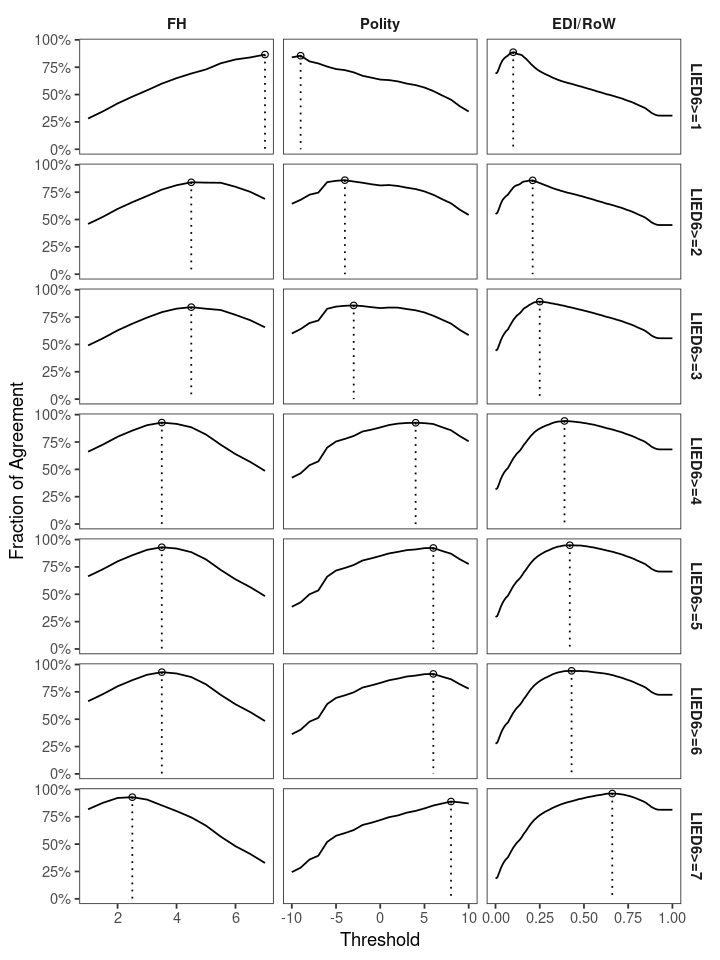

In [12]:
## Figure A2. Fraction of agreement with LIED benchmark

g <- ggplot(z, aes(threshold, agreement)) + 
  facet_grid(vars(lied6_class), vars(contVar), scales="free_x") +
  geom_line() +
  scale_y_continuous(labels=scales::percent_format(accuracy=1)) +
  theme(panel.grid.major=element_blank(),
        panel.grid.minor=element_blank()) +
  xlab("Threshold") + ylab("Fraction of Agreement") +
  geom_segment(aes(xend=threshold, yend=0), data=thres_lied6, linetype="dotted") +
  geom_point(data=thres_lied6, shape=1)

figsize(6, 8)
g
savefigs("figureA2_lied6-agreement", g, width=6, height=8)

In [13]:
## Table A3. Comparison with Mailwaring et al.

mainwaring2001 <- read_csv("mainwaring.csv.gz")
years <- data.frame(year=min(mainwaring2001$startyear):max(mainwaring2001$endyear))

mw <- sqldf("
SELECT
  y.year, m.country, m.regime
FROM
  years AS y
  INNER JOIN
    mainwaring2001 AS m
  ON
    y.year BETWEEN m.startyear AND m.endyear
")
# capitalize the first letter and factorize
mw$regime <- substring(mw$regime, 1, 1) %>% toupper() %>% paste0(substring(mw$regime, 2))
mw$regime <- factor(mw$regime, levels=c("Authoritarian", "Semi-democratic", "Democratic"))

# add suggested regime
makeRegimeData <- function(x, thres) {
  out <- select(x, countryName, year, Polyarchy, Polity, FH) %>%
    pivot_longer(cols=-c(countryName, year), names_to="contVar") %>%
    drop_na()
  out$contVar[out$contVar == "Polyarchy"] <- "EDI/RoW"
  thres$contVar <- as.character(thres$contVar)  # avoid factor coercing warning  
  out <- inner_join(out, thres)

  out <- out %>%
    mutate(
       democracyConventional=ifelse(contVar=="FH", 
                                 value <= conventional_threshold,
                                 value >= conventional_threshold)
      ,democracyOptimal=ifelse(contVar=="FH", 
                            value <= optimal_threshold,
                            value >= optimal_threshold)
    ) %>%
    mutate(regimeConventional=ifelse(democracyConventional, "Democracy", "Autocracy"),
           regimeOptimal=ifelse(democracyOptimal, "Democracy", "Autocracy"))
  out
}

tmp <- ungroup(u) %>% 
  filter(binVar=="Average") %>% 
  select(contVar, optimal_threshold, conventional_threshold) 
a <- makeRegimeData(x, tmp) %>% rename(country=countryName)

# check for country name match
cat("Uncovered countries:", setdiff(mw$country, a$country), "\n")

mw <- inner_join(mw, a)
head(mw)

b1 <- group_by(mw, contVar, regime, regimeConventional) %>% summarize(n=n()) %>%
  pivot_wider(id_cols=c(contVar, regime), values_from=n, 
              names_from=regimeConventional, values_fill=list(n=0)) %>%
  mutate(criteria="conventional")
b2 <- group_by(mw, contVar, regime, regimeOptimal) %>% summarize(n=n()) %>%
  pivot_wider(id_cols=c(contVar, regime), values_from=n, 
              names_from=regimeOptimal, values_fill=list(n=0)) %>%
  mutate(criteria="optimal")
b <- rbind(b1, b2) %>%
  mutate(N=Autocracy + Democracy) %>%
  mutate(autocracy_ratio=Autocracy/N, democracy_ratio=Democracy/N) %>%
  select(contVar, criteria, regime, autocracy_ratio, democracy_ratio, N, Autocracy, Democracy) %>%
  mutate(contVar=factor(contVar, levels=c("FH", "Polity", "EDI/RoW"))) %>%
  arrange(contVar, criteria, regime)

tmp <- b %>% pivot_wider(id_cols=c(contVar, regime), names_from=criteria, values_from=-c(contVar, regime, criteria, N))
tmp[c("contVar", "regime",
      "Autocracy_conventional", "Democracy_conventional", "autocracy_ratio_conventional", "democracy_ratio_conventional",
      "Autocracy_optimal", "Democracy_optimal", "autocracy_ratio_optimal", "democracy_ratio_optimal")]

Rows: 90 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): country, regime
dbl (2): startyear, endyear


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Joining, by = "contVar"



Uncovered countries:  


Joining, by = c("year", "country")



,year,country,regime,contVar,value,optimal_threshold,conventional_threshold,democracyConventional,democracyOptimal,regimeConventional,regimeOptimal
,<dbl>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>,<chr>
1,1945,Argentina,Authoritarian,EDI/RoW,0.094,0.39,0.5,FALSE,FALSE,Autocracy,Autocracy
2,1945,Argentina,Authoritarian,Polity,-8.000,5.00,6.0,FALSE,FALSE,Autocracy,Autocracy
3,1945,Bolivia,Authoritarian,EDI/RoW,0.113,0.39,0.5,FALSE,FALSE,Autocracy,Autocracy
4,1945,Bolivia,Authoritarian,Polity,-5.000,5.00,6.0,FALSE,FALSE,Autocracy,Autocracy
5,1945,Brazil,Authoritarian,EDI/RoW,0.107,0.39,0.5,FALSE,FALSE,Autocracy,Autocracy
6,1945,Brazil,Authoritarian,Polity,0.000,5.00,6.0,FALSE,FALSE,Autocracy,Autocracy


`summarise()` has grouped output by 'contVar', 'regime'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'contVar', 'regime'. You can override using the `.groups` argument.



contVar,regime,Autocracy_conventional,Democracy_conventional,autocracy_ratio_conventional,democracy_ratio_conventional,Autocracy_optimal,Democracy_optimal,autocracy_ratio_optimal,democracy_ratio_optimal
<fct>,<fct>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
FH,Authoritarian,192,7,0.9648241,0.03517588,162,37,0.814070352,0.18592965
FH,Semi-democratic,87,17,0.8365385,0.16346154,29,75,0.278846154,0.72115385
FH,Democratic,32,179,0.1516588,0.84834123,1,210,0.004739336,0.99526066
Polity,Authoritarian,486,10,0.9798387,0.02016129,486,10,0.979838710,0.02016129
Polity,Semi-democratic,122,82,0.5980392,0.40196078,100,104,0.490196078,0.50980392
Polity,Democratic,61,285,0.1763006,0.82369942,34,312,0.098265896,0.90173410
EDI/RoW,Authoritarian,496,0,1.0000000,0.00000000,491,5,0.989919355,0.01008065
EDI/RoW,Semi-democratic,158,46,0.7745098,0.22549020,108,96,0.529411765,0.47058824
EDI/RoW,Democratic,92,254,0.2658960,0.73410405,33,313,0.095375723,0.90462428


In [14]:
## Table A4. Comparition of thresholds by period

optimThreshold <- function(continuous, binary, thresholds, direc=`>=`) {
  # continuous: vector of continuous variables
  # binary    : vector of binary variables
  # thresholds: vectir of candidate thresholds
  # direc     : function of inequality 
  stopifnot(length(continuous) == length(binary))
  # remove NAs if any
  flg1 <- is.na(continuous)
  flg2 <- is.na(binary)
  flg <- (flg1 | flg2)
  if (sum(!flg) < 500) {
    message(sprintf("Non NA counts: %d, skipped", sum(!flg)))
    return(NULL)
  }
  #"NA counts: %d (continuous), %d (binary), %d (either, removed)" %>% sprintf(sum(flg1), sum(flg2), sum(flg)) %>% message()
  continuous <- continuous[!flg]
  binary <- binary[!flg] %>% as.integer()
  stopifnot(all(binary %in% c(0,1)))
  out <- c()
  for (th in thresholds) {
    tmp <- direc(continuous, th) %>% as.integer()
    out <- c(out, mean(tmp == binary))
  }
  data.frame(threshold=thresholds, nobs=sum(!flg), fracAgree=out)
}

candidateThresholds <- list(
   "Polyarchy" = seq(0, 1, 0.01)
  ,"Polity"    = seq(-10, 10, 1)
  ,"FH"        = seq(1, 7, 0.5)
)

directions <- list(
   "Polyarchy" = `>=`
  ,"Polity"    = `>=`
  ,"FH"        = `<=`
)

out <- NULL
periods  <- list("1900-2020"=c(1900, 2020), "1900-1945"=c(1900, 1945), "1946-2020"=c(1946, 2020))
contVars <- c("Polyarchy", "Polity")
binVars  <- c("BMR", "BMR_female",
              "lied6_1", "lied6_2", "lied6_3", "lied6_4", "lied6_5", "lied6_6", "lied6_7")

for (period in periods) {
  for (contVar in contVars) {
    for (binVar in binVars) {
      #cat(contVar, ",", binVar, ",", period[1], "~", period[2], "\n")
      flg <- (x$year >= period[1] & x$year <= period[2])
      tmp <- optimThreshold(x[flg, contVar], x[flg, binVar], candidateThresholds[[contVar]], directions[[contVar]])
      if (is.null(tmp)) next
      tmp$contVar <- contVar
      tmp$binVar  <- binVar
      tmp$period  <- sprintf("%d-%d", period[1], period[2])
      out <- rbind(out, tmp)
    }
  }
}

# factorize and rename for presentation
out <- out %>% mutate(
  period=factor(period, levels=names(periods)),
  contVar={if_else(contVar=="Polyarchy", "EDI/RoW", contVar) %>% factor(levels=c("Polity", "EDI/RoW"))},
  binVar={if_else(binVar=="BMR_female", "BMR-female", binVar) %>% str_replace("lied6_", "LIED6>=")}
)

# find optimal threshold
tmp <- group_by(out, period, binVar, contVar) %>% summarize(fracAgree=max(fracAgree)) %>% ungroup()
out2 <- merge(out, tmp) %>%
  group_by(period, binVar, contVar, nobs, fracAgree) %>%
  summarize(thresholds=paste0(threshold, collapse=","), threshold=median(threshold)) %>%
  ungroup() %>%
  arrange(period, contVar, binVar)

# pivot for better presentation
out2b <- out2 %>%
  pivot_wider(id_cols=c(contVar, binVar), names_from=period, values_from=c(threshold, fracAgree, nobs, thresholds))
out2b

`summarise()` has grouped output by 'period', 'binVar'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'period', 'binVar', 'contVar', 'nobs'. You can override using the `.groups` argument.



contVar,binVar,threshold_1900-2020,threshold_1900-1945,threshold_1946-2020,fracAgree_1900-2020,fracAgree_1900-1945,fracAgree_1946-2020,nobs_1900-2020,nobs_1900-1945,nobs_1946-2020,thresholds_1900-2020,thresholds_1900-1945,thresholds_1946-2020
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<chr>
Polity,BMR,5.00,6.000,5.00,0.9294275,0.9180801,0.9373362,11931,2771,9160,5,6,5
Polity,BMR-female,5.50,10.000,5.00,0.9130981,0.8860440,0.9353712,11933,2773,9160,"5,6",10,5
Polity,LIED6>=1,-9.00,-9.000,-9.00,0.8551915,0.8367564,0.8604817,12665,2824,9841,-9,-9,-9
Polity,LIED6>=2,-4.00,-4.000,-4.00,0.8595341,0.7999292,0.8766386,12665,2824,9841,-4,-4,-4
Polity,LIED6>=3,-3.00,-3.000,-4.00,0.8564548,0.7772663,0.8843613,12665,2824,9841,-3,-3,-4
Polity,LIED6>=4,4.00,6.000,4.00,0.9258587,0.8792493,0.9417742,12665,2824,9841,4,6,4
Polity,LIED6>=5,6.00,8.000,5.00,0.9233320,0.8799575,0.9390306,12665,2824,9841,6,8,5
Polity,LIED6>=6,6.00,10.000,5.00,0.9140150,0.8803116,0.9355757,12665,2824,9841,6,10,5
Polity,LIED6>=7,8.00,10.000,8.00,0.8893802,0.8675637,0.9059039,12665,2824,9841,8,10,8


In [15]:
# Show running environment info
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] sqldf_0.4-11  RSQLite_2.2.7 gsubfn_0.7    proto_1.0.0   stringr_1.4.0
 [6] cowplot_1.1.1 ggplot2_3.3.3 tidyr_1.1.3   dplyr_1.0.6   readr_2.0.2  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-5      tidyselect_1.1.1  repr_1.1.3        p